# BTC Strategy Design
***
## Import Package and Data

In [8]:
from datetime import datetime
from reference.Strategy import BaseStrategyFrame
from reference.Strategy import zwpy_sta
import pathlib
import backtrader as bt
import pyfolio as pf
import pandas as pd
import json


# route init
curr_folder = pathlib.Path().cwd()
BTC_data_min = curr_folder / "BTCUSDT_UPERP_1m.csv"

# report folder init
report_folder = curr_folder / "report"
if not report_folder.exists():
    report_folder.mkdir(parents=True, exist_ok=True)

data_folder = curr_folder / "data"
if not data_folder.exists():
    data_folder.mkdir(parents=True, exist_ok=True)



## Data Resample

In [9]:
BTC_data_min = pd.read_csv(BTC_data_min, parse_dates =["datetime"], index_col ="datetime")
print("Minute ohlc\n", BTC_data_min.head(10))
BTC_data = BTC_data_min.resample('h').mean()
print("\nHour ohlc\n", BTC_data.head(10))
BTC_data.to_csv(str(data_folder / "BTC_hour.csv"))
BTC_data = pathlib.Path().cwd() / "data" / "BTC_hour.csv"


Minute ohlc
                         open     high      low    close  volume
datetime                                                       
2019-09-25 15:44:00  8323.22  8348.51  8323.22  8345.08  15.878
2019-09-25 15:45:00  8346.57  8348.32  8339.09  8339.09  15.931
2019-09-25 15:46:00  8340.21  8341.79  8320.05  8320.77  29.408
2019-09-25 15:47:00  8320.77  8338.87  8320.77  8336.79  40.464
2019-09-25 15:48:00  8336.79  8342.28  8329.25  8340.73  34.654
2019-09-25 15:49:00  8343.46  8343.89  8338.15  8343.86  33.772
2019-09-25 15:50:00  8341.07  8364.00  8341.07  8360.93  43.837
2019-09-25 15:51:00  8359.17  8379.33  8352.64  8374.18  43.769
2019-09-25 15:52:00  8375.08  8380.26  8367.21  8374.61  55.568
2019-09-25 15:53:00  8374.02  8374.02  8343.37  8346.06  26.116

Hour ohlc
                             open         high          low        close  \
datetime                                                                  
2019-09-25 15:00:00  8343.848750  8353.017500  8334.82062

## Add strategy（from reference目錄） & initialize cerebro 設置初始資金

In [ ]:
cerebro = bt.Cerebro()
cerebro.addstrategy(zwpy_sta.MacdV2Strategy)
cerebro.broker.setcash(100000)

## Data format & Feed (backtrader)

In [10]:
dt_start = datetime.strptime("2019-09-25","%Y-%m-%d")
dt_end = datetime.strptime("2021-10-28","%Y-%m-%d")
data = bt.feeds.GenericCSVData(
    timeframe = bt.TimeFrame.Minutes,
    compression = 60,
    dataname=BTC_data,
    fromdate=dt_start,      
    todate=dt_end,
    nullvalue=0.0,
    dtformat=('%Y-%m-%d %H:%M:%S'),   
    datetime=0,             # 各列的位置，从0开始，如列缺失则为None，-1表示自动根据列名判断
    open = 1,
    high = 2,
    low = 3,
    close = 4,
    openinterest=-1,
    volume = -1
)
cerebro.adddata(data)

## Run Backtrader and return result to pyfolio

Starting Value: 100000.00
printlog: False
period_me1: 12
period_me2: 26
period_signal: 9
=== Backtesting Start! ===
=== Backtesting Finished! ===
Ending Value: 152852.72


<IPython.core.display.Javascript object>


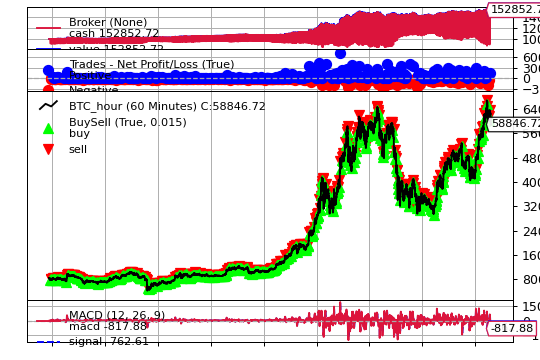

[[<Figure size 432x288 with 5 Axes>]]

In [11]:
print('Starting Value: %.2f' % cerebro.broker.getvalue())
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
print('Ending Value: %.2f' % cerebro.broker.getvalue())

cerebro.plot()

## Pyfolio 計算風險指標

Start date,2019-09-25
End date,2021-10-28
Total months,36
,Backtest
Annual return,15.001%
Cumulative returns,52.853%
Annual volatility,9.15%
Sharpe ratio,1.57
Calmar ratio,2.13
Stability,0.87
Max drawdown,-7.04%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.04,2021-03-15,2021-04-27,2021-08-21,115
1,4.82,2021-01-14,2021-02-01,2021-02-08,18
2,4.31,2021-02-22,2021-02-28,2021-03-05,10
3,2.57,2021-08-23,2021-09-01,2021-10-06,33
4,2.48,2021-01-07,2021-01-13,2021-01-14,6


<IPython.core.display.Javascript object>


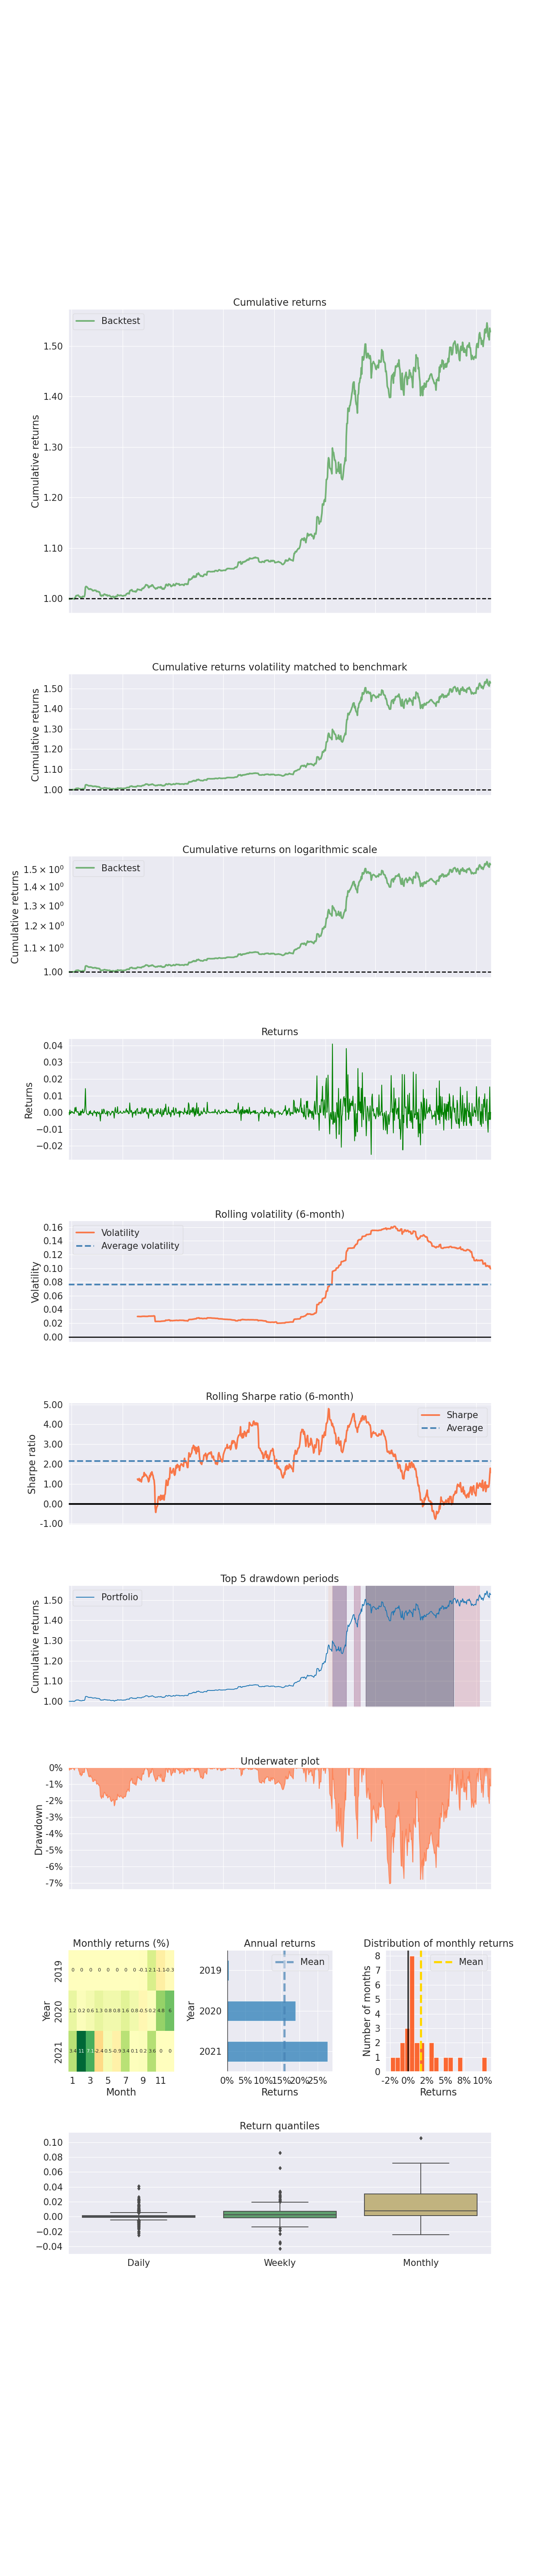

/home/thomas/Desktop/BTC/env/lib/python3.8/site-packages/pyfolio/timeseries.py:1230: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  period = returns_dupe.loc[start:end]


Stress Events,mean,min,max
New Normal,0.06%,-2.52%,4.09%


<IPython.core.display.Javascript object>


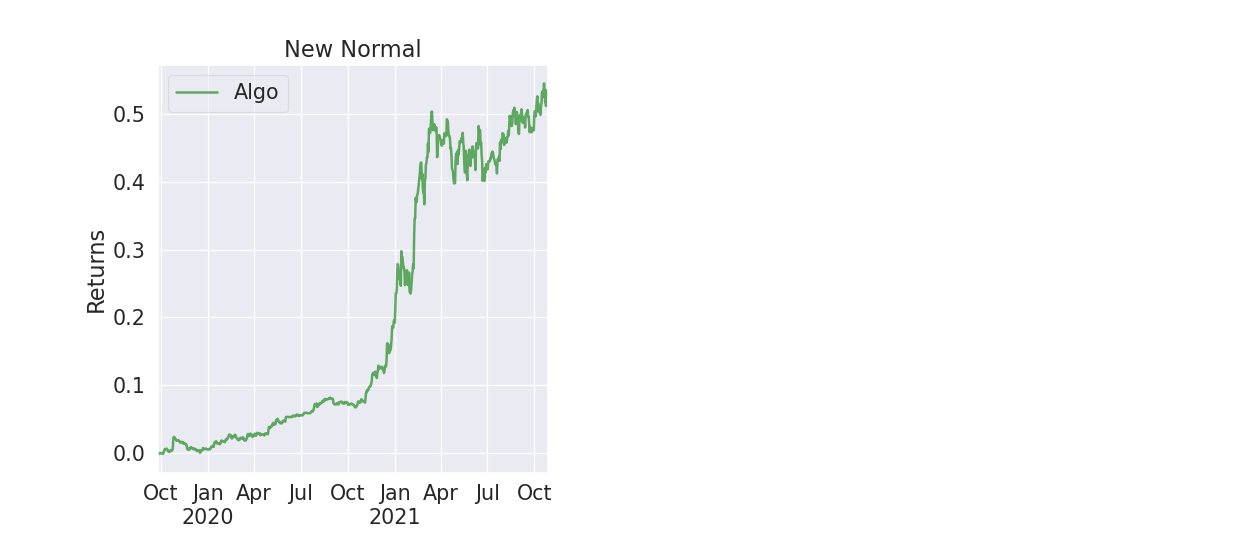

In [12]:
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(returns)

## Strategy

from /BTC/reference/Strategy/zwpy_sta.py<br>
class MacdV2Strategy<br>


    Rule:
        If MACD - MACD_signal > 0: buy.
        If MACD - MACD_signal < 0: sell.

    Args:
        fast_period (int): fast ema period.
        slow_period (int): slow ema period.
        signal_period (int): macd signal period.


## Train params
***
### Cutting row data Take 2021-01-01 as the boundary


In [ ]:
train = BTC_data[BTC_data.index < '2021-01-01 0:00:00']
test = BTC_data[BTC_data.index >= '2021-01-01 0:00:00']

### for loop to find the best returns (3 parameters)

In [ ]:
for fast_period in range(11,14):
    for slow_period in range(25,28):
        for signal_period in range(7,11):
            """
            Backtrader run Macd strategy and update the best params to json_file
            """

### Result 
> **params : (fast_period, slow_period, signal_period)<br><br>
> default params (12,26,9) `profit` <font color="#f00">19378.88</font> <br><br>
> training set best params (11, 26, 10) `profit` <font color="#f00">19584.45</font><br><br>
> testing set best params (11, 26, 10) `profit` <font color="#f00">35346.14</font><br><br>**
#### 出一張圖3種結果 default training set testing set

In [16]:
with open(str(report_folder / "params.json"), "r") as f:
    data = json.load(f)
    print(data)

{'train': {'default': {'fast_period': 12, 'slow_period': 26, 'signal_period': 9, 'starting_value': 100000, 'ending_value': 119378.88549999965, 'profit': 19378.885499999655}, 'best': {'fast_period': 11, 'slow_period': 26, 'signal_period': 10, 'starting_value': 100000, 'ending_value': 119584.45883333302, 'profit': 19584.458833333018}}, 'test': {'best': {'fast_period': 11, 'slow_period': 26, 'signal_period': 10, 'starting_value': 100000, 'ending_value': 135346.1493333333, 'profit': 35346.149333333306}}}
